In [6]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
from ctse.systems.ct_system import ct_system
import pandas as pd
import numpy as np

system = simplesystem(
     csvFuturesSimData(csv_data_paths=dict(
            csvFuturesAdjustedPricesData='ctse.data.adjusted_prices_csv',
            csvFuturesMultiplePricesData='ctse.data.multiple_prices_csv',
            csvFuturesInstrumentData='ctse.data.csvconfig'
    )),
    'paper.systems.china.yaml')
# system = ct_system()
rawdata = system.rawdata

perc_returns = [rawdata.get_daily_percentage_returns(instrument_code).rename(instrument_code) for instrument_code in system.get_instrument_list()]
perc_returns_df = pd.concat(perc_returns, axis=1)

2022-11-17 18:16:25 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2022-11-17 18:16:25 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2022-11-17 18:16:25 {'type': 'base_system', 'stage': 'config'}  Adding config defaults
2022-11-17 18:16:25 {'type': 'base_system'}  Following instruments are 'duplicate_markets' ['Another_thing', 'bad_thing'] 
2022-11-17 18:16:25 {'type': 'base_system'}  Following instruments are marked as 'ignore_instruments': not included: ['EXAMPLE']
2022-11-17 18:16:25 {'type': 'base_system'}  Following instruments removed entirely from sim: ['Another_thing', 'EXAMPLE', 'bad_thing']
2022-11-17 18:16:25 {'type': 'base_system', 'stage': 'rawdata', 'instrument_code': 'A'}  Calculating daily prices for A
2022-11-17 18:16:25 {'type': 'base_system', 'stage': 

2022-06-01 00:00:00
 [================================================================================] 100.0% Estimating correlations (0.0/0.0/0.0 secs left/elapsed/total) 


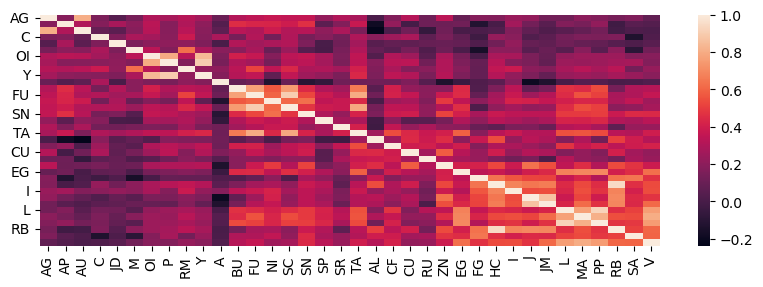

2021-07-01 00:00:00
 [================================================================================] 100.0% Estimating correlations (0.0/0.0/0.0 secs left/elapsed/total) 


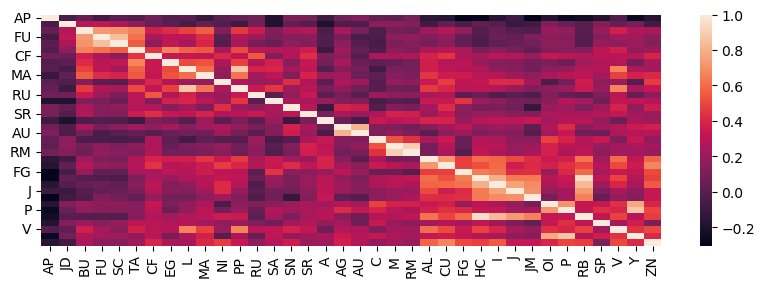

2020-07-31 00:00:00
 [================================================================================] 100.0% Estimating correlations (0.0/0.0/0.0 secs left/elapsed/total) 


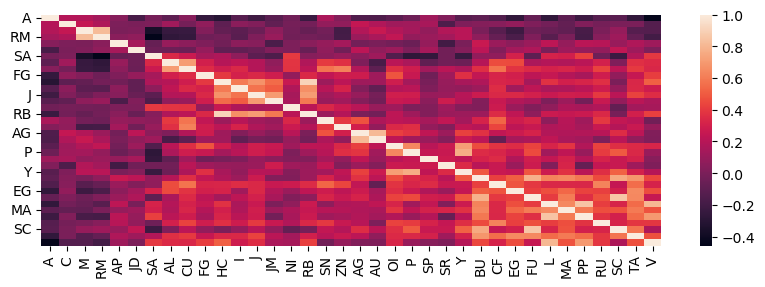

In [7]:
from sysquant.estimators.correlation_over_time import correlation_over_time_for_returns
from sysquant.fitting_dates import IN_SAMPLE
from syscore.objects import arg_not_supplied, resolve_function
from seaborn import heatmap
from copy import copy
import matplotlib.pyplot as plt
from sysquant.estimators.clustering_correlations import assets_in_cluster_order

config = system.config
corr_params = config.get_element_or_missing_data("instrument_returns_correlation")
corr_params = copy(corr_params)
corr_params["date_method"] = IN_SAMPLE
corr_func = resolve_function(corr_params.pop("func"))

for date in ['2022-06-01', '2021-07-01', '2020-08-01',]:
    sample = perc_returns_df.loc[perc_returns_df.index <=date]
    print(sample.index[-1])
    corr_matrix_list = corr_func(sample, **corr_params)
    correlation_matrix = corr_matrix_list.most_recent_correlation_before_date()
    cluster_size = min(5, int(correlation_matrix.size/3))
    new_order = assets_in_cluster_order(correlation_matrix, cluster_size=cluster_size)
    correlation_matrix = correlation_matrix.list_in_key_order(new_order)
    fig, ax = plt.subplots(figsize=(10,3))
    heatmap(correlation_matrix.as_pd(), ax=ax)
    plt.show()

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from scipy.cluster import hierarchy
import fastcluster
import matplotlib.pyplot as plt

def compute_sorted_correlations(corr):
    dist = 1 - corr.values
    tri_a, tri_b = np.triu_indices(len(dist), k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    permutation = hierarchy.leaves_list(
        hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b]))
    sorted_coins = corr.columns[permutation]
    sorted_corrs = corr.values[permutation, :][:, permutation]
    
    return pd.DataFrame(sorted_corrs, index=sorted_coins, columns=sorted_coins)


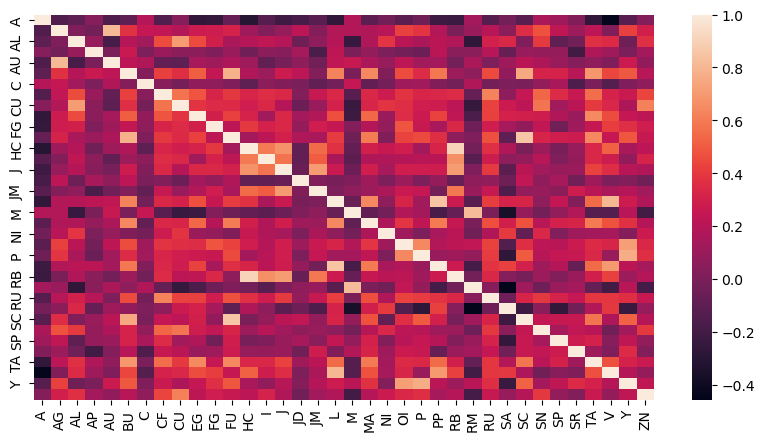

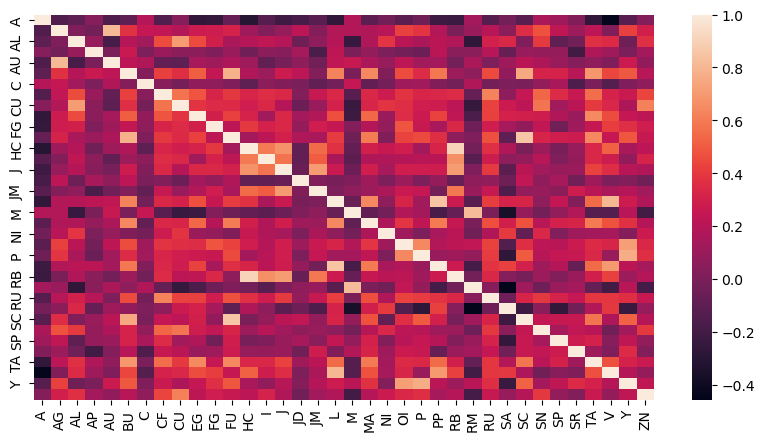

In [9]:
from seaborn import heatmap

for date in ['2022-8-01', '2021-8-01']:
    corr_matrix = corr_matrix_list.most_recent_correlation_before_date(pd.Timestamp(date)).as_pd()
    fig, ax = plt.subplots(figsize=(10,5))
    # sorted_correlations = compute_sorted_correlations(corr_matrix)
    _  = heatmap(corr_matrix)

<AxesSubplot:>

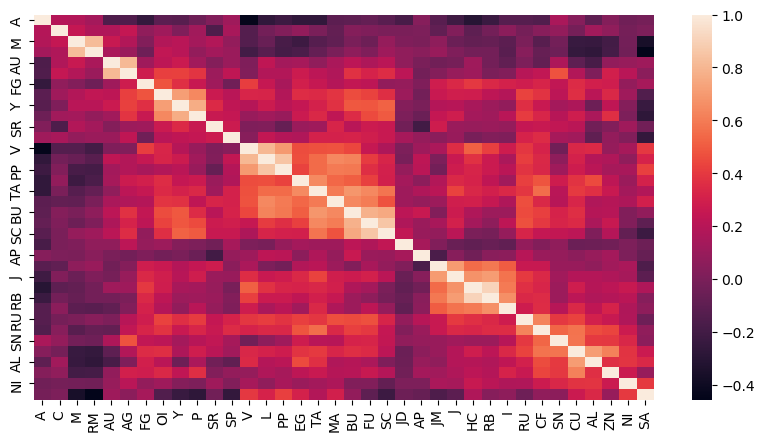

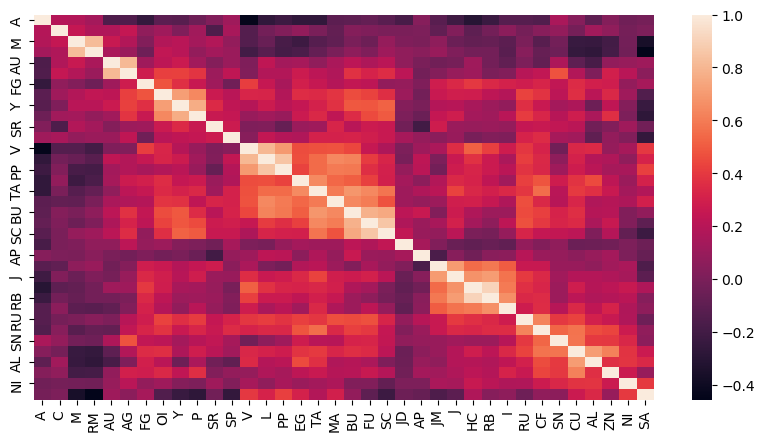

In [10]:


corr_matrix = corr_matrix_list.most_recent_correlation_before_date(pd.Timestamp('2021-8-01')).as_pd()
fig, ax = plt.subplots(figsize=(10,5))
sorted_correlations = compute_sorted_correlations(corr_matrix)
_  = heatmap(sorted_correlations)

corr_matrix = corr_matrix_list.most_recent_correlation_before_date(pd.Timestamp('2022-8-01')).as_pd()
fig, ax = plt.subplots(figsize=(10,5))
heatmap(corr_matrix[sorted_correlations.columns].loc[sorted_correlations.index])